In [1]:
!pip install -q scikit-learn pandas matplotlib joblib kaggle

In [3]:
from google.colab import files
import os
import pandas as pd
import seaborn as sns


In [4]:
from google.colab import files
uploaded = files.upload()

Saving Housing.csv to Housing.csv


In [5]:

import pandas as pd
import glob, os

# collect candidates in common places
candidates = glob.glob('/content/*.csv') + glob.glob('/content/**/*.csv', recursive=True) + glob.glob('/content/drive/**/*.csv', recursive=True)
candidates = [c for c in candidates if 'kaggle' not in c]  # optional filter
if not candidates:
    raise FileNotFoundError("No CSV found. Upload a CSV or run the Kaggle download cell.")
print("Using file:", candidates[0])
df = pd.read_csv(candidates[0])
print("Shape:", df.shape)
df.head()


Using file: /content/Housing.csv
Shape: (545, 13)


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [6]:
# Cell E: EDA & detect likely target column
import numpy as np
print("Columns:", list(df.columns))
print("\nInfo:")
display(df.info())
display(df.describe(include='all').T)

# Attempt to auto-detect the target column
candidates_targets = ['price','Price','saleprice','SalePrice','Sale Price','target','y','Y']
target_col = None
for t in candidates_targets:
    if t in df.columns:
        target_col = t
        break

# fallback: choose the last numeric column (not ideal but robust)
if target_col is None:
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if len(numeric_cols) == 0:
        raise ValueError("No numeric columns found to act as target. Please manually specify the target column.")
    # heuristic: pick a numeric column that is not an index/id
    non_id = [c for c in numeric_cols if c.lower() not in ['id','serial','index']]
    target_col = non_id[-1] if non_id else numeric_cols[-1]

print("Selected target column:", target_col)


Columns: ['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'parking', 'prefarea', 'furnishingstatus']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6),

None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
price,545.0,NaN,NaN,NaN,4766729.247706,1870439.615657,1750000.0,3430000.0,4340000.0,5740000.0,13300000.0
area,545.0,NaN,NaN,NaN,5150.541284,2170.141023,1650.0,3600.0,4600.0,6360.0,16200.0
bedrooms,545.0,NaN,NaN,NaN,2.965138,0.738064,1.0,2.0,3.0,3.0,6.0
bathrooms,545.0,NaN,NaN,NaN,1.286239,0.50247,1.0,1.0,1.0,2.0,4.0
stories,545.0,NaN,NaN,NaN,1.805505,0.867492,1.0,1.0,2.0,2.0,4.0
mainroad,545,2,yes,468,NaN,NaN,NaN,NaN,NaN,NaN,NaN
guestroom,545,2,no,448,NaN,NaN,NaN,NaN,NaN,NaN,NaN
basement,545,2,no,354,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hotwaterheating,545,2,no,520,NaN,NaN,NaN,NaN,NaN,NaN,NaN
airconditioning,545,2,no,373,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Selected target column: price


In [7]:
# Cell F: Simple preprocessing: fill NA, drop ID cols, one-hot encode categoricals
df2 = df.copy()

# drop common ID columns
for idc in ['id','Id','ID','index','Index']:
    if idc in df2.columns:
        df2 = df2.drop(columns=[idc])

# fill numeric with median, categorical with mode
num_cols = df2.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df2.select_dtypes(include=['object','category']).columns.tolist()

for c in num_cols:
    df2[c] = df2[c].fillna(df2[c].median())
for c in cat_cols:
    if not df2[c].mode().empty:
        df2[c] = df2[c].fillna(df2[c].mode().iloc[0])
    else:
        df2[c] = df2[c].fillna('missing')

# One-hot encode categorical features (drop_first to avoid dummy trap)
df_enc = pd.get_dummies(df2, columns=cat_cols, drop_first=True)

# Ensure target still exists after encoding
if target_col not in df_enc.columns:
    # if target was categorical and got one-hot encoded, try original
    if target_col in df2.columns:
        # move target back if changed
        pass

print("Preprocessed shape:", df_enc.shape)
X = df_enc.drop(columns=[target_col])
y = df_enc[target_col]


Preprocessed shape: (545, 14)


In [8]:
# Cell G: Split, scale, fit Linear Regression and compute metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# fit linear regression
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# predict + metrics
y_pred = model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R^2: {r2:.4f}")

# coefficients (map back to feature names)
import pandas as pd
coeffs = pd.Series(model.coef_, index=X_train.columns).sort_values(ascending=False)
print("\nTop positive coefficients:\n", coeffs.head(10))
print("\nTop negative coefficients:\n", coeffs.tail(10))
print("\nIntercept:", model.intercept_)


MAE: 970043.4039
MSE: 1754318687330.6677
R^2: 0.6529

Top positive coefficients:
 bathrooms              521879.027748
area                   519552.416340
airconditioning_yes    365157.393851
stories                349251.438906
prefarea_yes           266656.351993
parking                192005.953667
basement_yes           187067.803214
hotwaterheating_yes    149862.702991
mainroad_yes           128498.628215
guestroom_yes           88768.667686
dtype: float64

Top negative coefficients:
 stories                            349251.438906
prefarea_yes                       266656.351993
parking                            192005.953667
basement_yes                       187067.803214
hotwaterheating_yes                149862.702991
mainroad_yes                       128498.628215
guestroom_yes                       88768.667686
bedrooms                            57349.559419
furnishingstatus_semi-furnished    -62837.321865
furnishingstatus_unfurnished      -192015.917982
dtype: float64

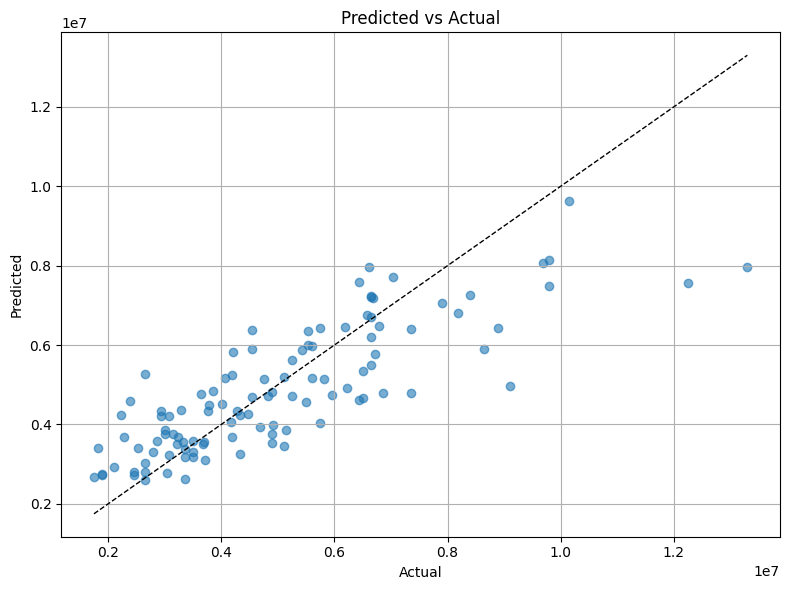

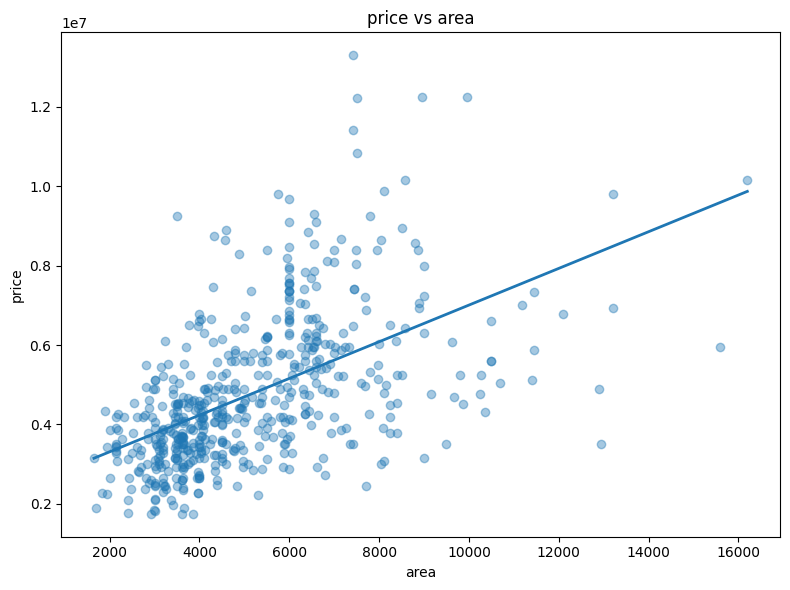

In [9]:
# Cell H: Save plots to file and display
import matplotlib.pyplot as plt
import numpy as np
import os

# ensure output dir
out_dir = "/content/drive/MyDrive/Task3_outputs"
os.makedirs(out_dir, exist_ok=True)

# Predicted vs Actual
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6)
minv = min(y_test.min(), y_pred.min())
maxv = max(y_test.max(), y_pred.max())
plt.plot([minv,maxv], [minv,maxv], 'k--', linewidth=1)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "pred_vs_actual.png"))
plt.show()

# Simple regression: find top correlated numeric feature with target and plot
if len(X.columns) > 0:
    corr = df_enc.corr().abs()[target_col].sort_values(ascending=False)
    # take the top numeric feature that is not the target itself
    top_feat = [c for c in corr.index if c != target_col and c in X.columns][0]
    plt.figure(figsize=(8,6))
    plt.scatter(df_enc[top_feat], df_enc[target_col], alpha=0.4)
    # fit a simple line
    from sklearn.linear_model import LinearRegression
    lr = LinearRegression()
    X_feat = df_enc[[top_feat]].values
    y_feat = df_enc[target_col].values
    lr.fit(X_feat, y_feat)
    x_line = np.linspace(X_feat.min(), X_feat.max(), 100).reshape(-1,1)
    y_line = lr.predict(x_line)
    plt.plot(x_line, y_line, linewidth=2)
    plt.xlabel(top_feat)
    plt.ylabel(target_col)
    plt.title(f"{target_col} vs {top_feat}")
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, "simple_regression.png"))
    plt.show()
else:
    print("Not enough features to plot simple regression.")


In [10]:
# Cell I: Save model and scaler using joblib
import joblib, os
os.makedirs(out_dir, exist_ok=True)
joblib.dump(model, os.path.join(out_dir, 'linear_regression_model.joblib'))
joblib.dump(scaler, os.path.join(out_dir, 'scaler.joblib'))
print("Saved model and scaler to:", out_dir)


Saved model and scaler to: /content/drive/MyDrive/Task3_outputs


In [11]:


files.download(os.path.join(out_dir, 'linear_regression_model.joblib'))
files.download(os.path.join(out_dir, 'scaler.joblib'))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
files.download(os.path.join(out_dir, 'pred_vs_actual.png'))
files.download(os.path.join(out_dir, 'simple_regression.png'))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>